In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/lfw-deepfunneled')

In [0]:
! ls

1_mercedes			 Josh_Kronfeld
1_Padmini			 Joshua_Davey
1_ramdas			 Joshua_Gracin
1_santosh			 Joshua_Harapko
1_Shashank			 Joshua_Perper
1_srikar			 Joxel_Garcia
Aaron_Eckhart			 Joy_Bryant
Aaron_Guiel			 Joy_Lee_Sadler
Aaron_Patterson			 JP_Suarez
Aaron_Peirsol			 JT_Snow
Aaron_Pena			 Juan_Antonio_Samaranch
Aaron_Sorkin			 Juan_Carlos
Aaron_Tippin			 Juan_Carlos_Ferrero
Abba_Eban			 Juan_Carlos_Morales
Abbas_Kiarostami		 Juan_Carlos_Ortega
Abdel_Aziz_Al-Hakim		 Juanes
Abdel_Madi_Shabneh		 Juan_Fernandez
Abdel_Nasser_Assidi		 Juan_Francisco_Palencia
Abdoulaye_Wade			 Juan_Ignacio_Chela
Abdulaziz_Kamilov		 Juan_Jose_Lucas
Abdullah			 Juan_Manuel_Marquez
Abdullah_Ahmad_Badawi		 Juan_Pablo_Montoya
Abdullah_al-Attiyah		 Juan_Roman_Carrasco
Abdullah_Gul			 Juan_Roman_Riquelme
Abdullah_Nasseef		 Juan_Sanchez
Abdullatif_Sener		 Juan_Valencia_Osorio
Abdul_Majeed_Shobokshi		 Judd_Davies
Abdul_Rahman			 Jude_Law
Abel_Aguilar			 Judi_Dench
Abel_Pacheco			 Judi_Patton
Abid_Hamid_Mahmud_Al-Tikriti	

In [0]:
import tensorflow.keras.backend as backend
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dot,Conv2D,MaxPool2D,Flatten,BatchNormalization,Activation
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
PATH="/content/drive/My Drive/Colab Notebooks/lfw-deepfunneled/"
dirs = sorted(os.listdir(PATH))
print("Total number of classes  (person ) in the full dataset:",len(dirs))

dirs = dirs[:100]

print("Total number of classes considered:",len(dirs))

Total number of classes  (person ) in the full dataset: 5756
Total number of classes considered: 100


In [0]:

name_to_classid = {d: i for i ,d in enumerate(dirs)}


In [0]:
classid_to_name = {v:k for k,v in name_to_classid.items()}


In [0]:
img_paths = {c: [PATH+subfolder+"/"+img
                 for img in sorted(os.listdir(PATH+subfolder))]
              for subfolder,c in name_to_classid.items()}


In [0]:
all_images_paths = []
for img_list in img_paths.values():
  all_images_paths+= img_list 

path_to_imageid = {v:k for k,v in enumerate(all_images_paths)}
imageid_to_path = {v:k for k,v in path_to_imageid.items()}

classid_to_imageid = {k:[path_to_imageid[path] for path in v] for k,v in img_paths.items()}
imageid_to_classid = {v:c for c,imgs in classid_to_imageid.items() for v in imgs}


In [0]:
def build_pos_pairs_for_imageid(classid):
  imgs=classid_to_imageid[classid]
  if len(imgs)==1:
    return {}
  pos_pairs = [(imgs[i],imgs[j]) 
              for i in range(len(imgs))
              for j in range(len(imgs))
              ]
  random.shuffle(pos_pairs)
  return pos_pairs              

In [0]:
def build_neg_pairs_for_imgid(classid,classes,max_num=20):
  imgs = classid_to_imageid[classid]
  neg_classes_imageid = random.sample(classes,max_num+1)
  if classid in neg_classes_imageid:
    neg_classes_imageid.remove(classid)
  neg_pairs=[]
  for id2 in range(max_num):
    img1 = imgs[random.randint(0,len(imgs)-1)]
    imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
    img2 = imgs2[random.randint(0,len(imgs2)-1)]
    if (img1,img2) not in neg_pairs:
      neg_pairs +=[(img1,img2)]
  return neg_pairs  

In [0]:
def open_all_images(id_to_path):
  all_imgs = []
  i=0
  for path in imageid_to_path.values():
    temp = cv2.imread(path)
    temp = cv2.resize(temp,(100,100))  
    all_imgs += [np.expand_dims(temp,0)]
    print(f"Opened and processed {i+1}th image")
    i=i+1
  return np.vstack(all_imgs)  

In [0]:
def build_train_test_data(num_classes,split=0.7):
  listX1 = []
  listX2 = []
  listY = []
  split = int(num_classes*split)
  for id in range(split):
    pos = build_pos_pairs_for_imageid(id)
    neg = build_neg_pairs_for_imgid(id,list(range(split)))
    for pair in pos:
      listX1 +=[pair[0]]
      listX2 +=[pair[1]]
      listY += [1]
    for pair in neg:
      listX1 +=[pair[0]]
      listX2 +=[pair[1]]
      listY += [0]
  perm = np.random.permutation(len(listX1))
  X1_ids_train = np.array(listX1)[perm]
  X2_ids_train = np.array(listX2)[perm]
  Y_ids_train = np.array(listY)[perm]
  listX1 = []
  listX2 = []
  listY = []

  #train
  for id in range(split,num_classes):
    pos = build_pos_pairs_for_imageid(id)

    neg = build_neg_pairs_for_imgid(id,list(range(split,num_classes)))
    
    for pair in pos:
      listX1 +=[pair[0]]
      listX2 +=[pair[1]]
      listY += [1]
    for pair in neg:
      listX1 +=[pair[0]]
      listX2 +=[pair[1]]
      listY += [0]
  X1_ids_test = np.array(listX1)
  X2_ids_test = np.array(listX2)
  Y_ids_test = np.array(listY)
  return (X1_ids_train,X2_ids_train,Y_ids_train,X1_ids_test,X2_ids_test,Y_ids_test)

In [0]:
class Generator:
  def __init__(self,X1,X2,Y,batch_size,all_imgs):
    self.cur_train_index=0
    self.X1=X1
    self.X2=X2
    self.Y = Y
    self.imgs = all_imgs
    self.batch_size=batch_size
    self.num_samples = Y.shape[0]

  def next_train(self):
    while 1:
      #print(self.cur_train_index)
      self.cur_train_index += self.batch_size
      if self.cur_train_index >= self.num_samples:
        #print(self.cur_train_index)
        self.cur_train_index=0
      imgs1=self.X1[self.cur_train_index:self.cur_train_index+self.batch_size]
      imgs2=self.X2[self.cur_train_index:self.cur_train_index+self.batch_size]
      yield([self.imgs[imgs1],self.imgs[imgs2]],self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])    

In [0]:
num_classes= len(name_to_classid)
print(num_classes)
X1_ids_train,X2_ids_train,train_Y,X1_ids_test,X2_ids_test,test_Y = build_train_test_data(num_classes)


100


In [0]:
all_imgs = open_all_images(imageid_to_path)

Opened and processed 1th image
Opened and processed 2th image
Opened and processed 3th image
Opened and processed 4th image
Opened and processed 5th image
Opened and processed 6th image
Opened and processed 7th image
Opened and processed 8th image
Opened and processed 9th image
Opened and processed 10th image
Opened and processed 11th image
Opened and processed 12th image
Opened and processed 13th image
Opened and processed 14th image
Opened and processed 15th image
Opened and processed 16th image
Opened and processed 17th image
Opened and processed 18th image
Opened and processed 19th image
Opened and processed 20th image
Opened and processed 21th image
Opened and processed 22th image
Opened and processed 23th image
Opened and processed 24th image
Opened and processed 25th image
Opened and processed 26th image
Opened and processed 27th image
Opened and processed 28th image
Opened and processed 29th image
Opened and processed 30th image
Opened and processed 31th image
Opened and proces

In [0]:
print(f"Total images considered {len(all_imgs)}")

Total images considered 255


In [0]:
gen = Generator(X1_ids_train,X2_ids_train,train_Y,32,all_imgs)

In [0]:

[x1,x2],y = next(gen.next_train())

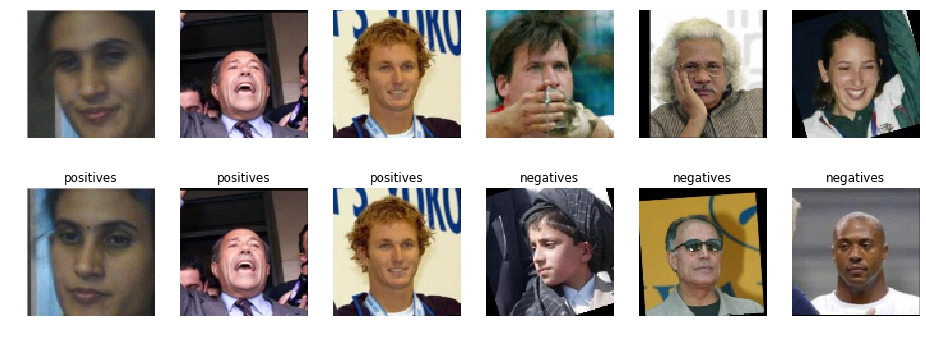

In [0]:
plt.figure(figsize=(16,6))
for i in range(6):
  plt.subplot(2,6,i+1)
  plt.imshow(cv2.cvtColor(x1[i],cv2.COLOR_BGR2RGB))
  plt.axis('off')
for i in range(6):
  plt.subplot(2,6,i+7)
  plt.imshow(cv2.cvtColor(x2[i],cv2.COLOR_BGR2RGB))
  plt.axis('off')  
  if y[i]==1.0:
    plt.title("positives")
  else:
    plt.title("negatives")
  plt.axis('off')
plt.show()      

In [0]:
#Making use of yann.lecun's Contrastive loss function

def contrastive_loss(y_true,y_pred,margin=0.2):
  return backend.mean(y_true*backend.square(1-y_pred) + (1-y_true)*backend.square(backend.maximum(y_pred-margin,0)))

def accuracy_sim(y_true,y_pred,threshold=0.5):
  y_threshold = backend.cast(y_pred>threshold,y_true.dtype)
  return backend.mean(backend.equal(y_true,y_threshold))


In [0]:
inp = Input(shape=(100,100,3),dtype='float32')
x = Conv2D(64,(3,3),padding='same',activation='relu')(inp)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3,3),padding='same',activation='relu')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(16,(3,3),padding='same',activation='relu')(x)
#x = MaxPool2D((2,2))(x)
x = Conv2D(16,(3,3),padding='same',activation='relu')(x)
#x = MaxPool2D((2,2))(x)
#x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(50)(x)
shared_conv = Model(inputs = inp, outputs=x)
print(shared_conv.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        4624      
______________________________________________

In [0]:
i1 = Input(shape=(100,100,3),dtype='float32')
i2 = Input(shape=(100,100,3),dtype='float32')

x1 = shared_conv(i1)
x2 = shared_conv(i2)

out = Dot(axes=-1,normalize=True)([x1,x2])
modelGo = Model(inputs=[i1,i2],outputs=out)
modelGo.compile(loss = contrastive_loss,optimizer='rmsprop',metrics=[accuracy_sim])

modelGo.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 50)           527250      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1)            0           model[1][0]                

In [0]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger

In [0]:
NUM_EPOCH = 40
model_name = "Siamese_network"
filepath = "/content/drive/My Drive/Colab Notebooks/"+model_name+'.h5py'


In [0]:
checkpoint = ModelCheckpoint(filepath,monitor = 'val_acc',verbose=0,save_best_only=True,mode='max')
csv_logger = CSVLogger("/content/drive/My Drive/Colab Notebooks/"+model_name+".csv")
callbacks_list = [checkpoint,csv_logger]


In [0]:
modelGo.fit_generator(generator = gen.next_train(),steps_per_epoch = train_Y.shape[0] // 32,epochs = NUM_EPOCH,validation_data = ([test_X1,test_X2],test_Y),callbacks=callbacks_list)

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
86/86 [==============================] - 8s 89ms/step - loss: 0.1183 - accuracy_sim: 0.7282 - val_loss: 0.1283 - val_accuracy_sim: 0.7603
Epoch 2/40
86/86 [==============================] - 5s 64ms/step - loss: 0.0224 - accuracy_sim: 0.9393 - val_loss: 0.1294 - val_accuracy_sim: 0.7793
Epoch 3/40
86/86 [==============================] - 5s 61ms/step - loss: 0.0071 - accuracy_sim: 0.9858 - val_loss: 0.1172 - val_accuracy_sim: 0.7768
Epoch 4/40
86/86 [==============================] - 5s 60ms/step - loss: 0.0031 - accuracy_sim: 0.9953 - val_loss: 0.1162 - val_accuracy_sim: 0.7914
Epoch 5/40
86/86 [==============================] - 5s 60ms/step - loss: 0.0015 - accuracy_sim: 0.9982 - val_loss: 0.1069 - val_accuracy_sim: 0.7869
Epoch 6/40
86/86 [==============================] - 5s 60ms/step - loss: 8.7301e-04 - accuracy_sim: 1.0000 - val_loss: 0.1112 - val_accuracy_sim: 0.7917
Epoch 7/

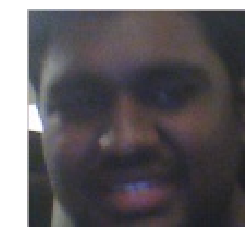

In [0]:
l = len(all_imgs)
query = 45#random.randint(0,l-1)
query_image = all_imgs[query]
plt.figure()
plt.imshow(cv2.cvtColor(query_image,cv2.COLOR_BGR2RGB)/255)
plt.axis('off')
plt.show()
plt.close()

In [0]:
query_image = cv2.resize(query_image,(100,100))
pred_vals = shared_conv.predict(np.expand_dims(query_image,0))

In [0]:
np.linalg.norm(pred_vals)

10095.008

In [0]:
def cal_sims(img1,img2):
  image1_coeff = shared_conv.predict(np.expand_dims(img1,0))
  image2_coeff = shared_conv.predict(np.expand_dims(img2,0))
  sims = np.inner(image1_coeff/np.linalg.norm(image1_coeff),image2_coeff/np.linalg.norm(image2_coeff))
  return sims[0]

dist={}
for i in range(l):
  if i!=query:
    img = cv2.resize(all_imgs[i],(100,100))
    dist[i] = cal_sims(query_image,img)

plt.figure()
for i in range(69):
  print(i)
  ind = max(dist,key=dist.get)
  print(ind)
  plt.title(f"Cost:{dist[ind]}")
  plt.imshow(cv2.cvtColor(all_imgs[ind],cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()
  plt.close()
  dist.pop(ind)




In [0]:
import tensorflow as tf
from tensorflow.python.framework import graph_io

In [0]:
sess = backend.get_session()
frozen = tf.graph_util.convert_variables_to_constants(sess,sess.graph_def,[out.op.name for out in shared_conv.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [0]:
graph_io.write_graph(frozen,'./','siamese.pb',as_text=False)

'./siamese.pb'